In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.externals import joblib
from PIL import Image

In [2]:
isize=256
bsize=32
channel=3
epochs=30

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"photos",shuffle=True,image_size=(isize,isize),batch_size=bsize)

Found 2610 files belonging to 4 classes.


In [4]:
x=dataset.class_names

In [5]:
x[0]

'Potato___Early_blight'

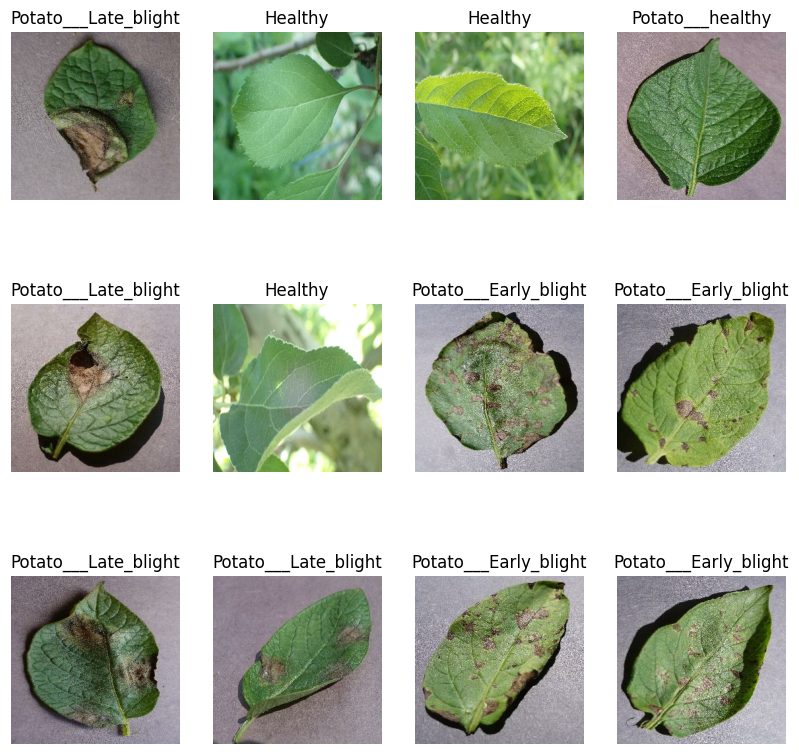

In [5]:
plt.figure(figsize=(10 ,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(x[label_batch[i]])
        plt.axis('off')

In [6]:
#80% ==> training
#20% ==> 10% validation, 10% test
p=len(dataset)*0.8
display(p)

65.60000000000001

In [7]:
trainds=dataset.take(54)
testds=dataset.skip(54)
len(dataset)*0.1

8.200000000000001

In [8]:
valds=testds.take(6)
len(valds)

6

In [9]:
testds=dataset.skip(6)

In [10]:
def get_dataset_partitions(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    ds.skip(train_size)
    val_ds=ds.take(val_size)
    ds.skip(val_size)
    test_ds=ds.take(val_size)
    return train_ds,val_ds,test_ds

In [11]:
train_ds, val_ds, test_ds=get_dataset_partitions(dataset)

In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
rr=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(isize,isize),
                     layers.experimental.preprocessing.Rescaling(1.0/255)])

In [14]:
da=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                     layers.experimental.preprocessing.RandomRotation(0.2)])

In [15]:
#Build the CNN model
input_shape=(bsize, isize, isize, channel)
model = models.Sequential([
    rr,
    da,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(isize, isize, channel)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(dataset.class_names), activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 127, 127, 64)        18496     
                                                      

In [16]:
# # Compile the model
model.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [17]:
# # Train the model
history = model.fit(train_ds,epochs=epochs,batch_size=bsize,verbose=1, validation_data=val_ds)

Epoch 1/30


C:\Users\mathe_thld2cd\AppData\Roaming\Python\Python311\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


65/65 [==============================] - 149s 2s/step - loss: 1.2128 - accuracy: 0.4313 - val_loss: 1.2593 - val_accuracy: 0.4766
Epoch 2/30
65/65 [==============================] - 110s 2s/step - loss: 0.8486 - accuracy: 0.6592 - val_loss: 0.6914 - val_accuracy: 0.7422
Epoch 3/30
65/65 [==============================] - 110s 2s/step - loss: 0.5100 - accuracy: 0.8040 - val_loss: 0.5239 - val_accuracy: 0.8438
Epoch 4/30
65/65 [==============================] - 113s 2s/step - loss: 0.4170 - accuracy: 0.8388 - val_loss: 0.7220 - val_accuracy: 0.6562
Epoch 5/30
65/65 [==============================] - 99s 2s/step - loss: 0.3264 - accuracy: 0.8727 - val_loss: 0.4873 - val_accuracy: 0.8125
Epoch 6/30
65/65 [==============================] - 98s 2s/step - loss: 0.2781 - accuracy: 0.8882 - val_loss: 0.2636 - val_accuracy: 0.9141
Epoch 7/30
65/65 [==============================] - 99s 2s/step - loss: 0.2679 - accuracy: 0.9027 - val_loss: 0.6144 - val_accuracy: 0.7344
Epoch 8/30
65/65 [=========

scores=model.evaluate(test_ds)

In [18]:

# # Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

8/8 [==============================] - 17s 320ms/step - loss: 0.0729 - accuracy: 0.9688
Test Loss: 0.07286719977855682
Test Accuracy: 0.96875


In [20]:
# model.save('healplant.keras')

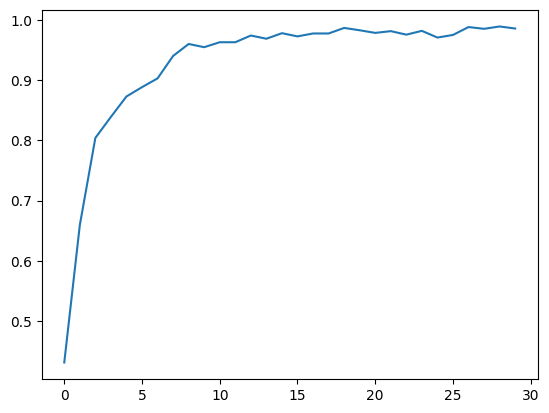

In [19]:
plt.plot(range(epochs),history.history['accuracy'])

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 526ms/step
Potato___Late_blight


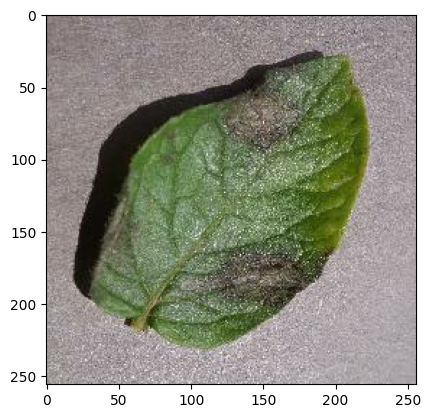

In [22]:
for images_batch, labels_batch in test_ds.take(1):
 first_image = images_batch[0].numpy() .astype('uint8')
 first_label = labels_batch[0].numpy()
 print("first image to predict")
 plt. imshow(first_image)
 print("actual label:",x[first_label])
 batch_prediction = model. predict (images_batch)
 print(x[np.argmax(batch_prediction[0])])

In [23]:
joblib.dump(model,'helpplant')

['helpplant']

In [20]:
# Load the model
loaded_model = joblib.load('helpplant')

# Open and load the image using Pillow
image = Image.open('h.jpg')

# Check if the image was loaded successfully
if image is not None:
    # Resize the image to the desired size (e.g., 224x224)
    image = image.resize((256, 256))

    # Convert the image to float32
    image = np.array(image, dtype=np.float32)

    # Normalize pixel values to the range [0, 1]
    image /= 255.0

    # Make predictions using the loaded model
    predictions = loaded_model.predict(np.expand_dims(image, axis=0))

    # Print the predictions or perform further actions
    print(x[np.argmax(predictions)])
    #print(predictions)
else:
    print("Failed to load the image.")

1/1 [==============================] - 0s 279ms/step
Healthy
